<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Using-3-Different-Groups-(Small,-Medium,-Large)" data-toc-modified-id="Using-3-Different-Groups-(Small,-Medium,-Large)-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Using 3 Different Groups (Small, Medium, Large)</a></span></li><li><span><a href="#Disposal-Time-=-2" data-toc-modified-id="Disposal-Time-=-2-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Disposal Time = 2</a></span></li><li><span><a href="#Disposal-Time-=-6" data-toc-modified-id="Disposal-Time-=-6-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Disposal Time = 6</a></span></li><li><span><a href="#Adding-Mutation-(Disposal-Time-=4)" data-toc-modified-id="Adding-Mutation-(Disposal-Time-=4)-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Adding Mutation (Disposal Time =4)</a></span></li><li><span><a href="#Adding-Mutation-(Disposal-Time-=2)" data-toc-modified-id="Adding-Mutation-(Disposal-Time-=2)-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Adding Mutation (Disposal Time =2)</a></span></li><li><span><a href="#Adding-Mutation-(Disposal-Time-=6)" data-toc-modified-id="Adding-Mutation-(Disposal-Time-=6)-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Adding Mutation (Disposal Time =6)</a></span></li></ul></div>

In [1]:
import pandas as pd
import numpy as np
import math
import random
import itertools
from functools import reduce
import matplotlib.pyplot as plt
import seaborn as sns


def create_pool(size):
    '''
    Creating an initial population containing 4 different types of
    individuals:

    SL: Selfish and Large
    SS: Selfish and Small
    SM: Selfish and Medium
    CL: Cooperative and Large
    CS: Cooperative and Small
    CM: Cooperative and Medium
    '''
    res = np.repeat(['SL', 'SS', 'SM', 'CL', 'CS', 'CM'], size/6)
    random.shuffle(res)
    return res


def divide_in_groups(pool, large_g=40, small_g=4, medium_g=22):
    '''
    Dividing the current population into two main divisions: one containing
    all the different types of large individuals and one containing instead
    all the types of small individuals. These two divisions are additionally
    splitted in multiple groups depending on the large_g and small_g parameters
    which represent respectively the fixed group size that each large and small
    group should have. If there are not enough individuals left to fill a group
    they are automatically discarded.
    '''
    large = [ind for ind in pool if ind[1] == 'L']
    small = [ind for ind in pool if ind[1] == 'S']
    medium = [ind for ind in pool if ind[1] == 'M']
    discard_large = int(large_g*(len(large)/large_g - math.floor(len(large)/large_g)))
    discard_small = int(small_g*(len(small)/small_g - math.floor(len(small)/small_g)))
    discard_medium = int(medium_g*(len(medium)/medium_g - math.floor(len(medium)/medium_g)))
    try:
        groups_l = np.array(large[: len(large) - discard_large])
        groups_l = groups_l.reshape(math.floor(len(large)/large_g), -1)
    except:
        if groups_l.size == 0:
            groups_s = np.array(small[: len(small) - discard_small])
            groups_s = groups_s.reshape(math.floor(len(small)/small_g), -1)
            groups_m = np.array(medium[: len(medium) - discard_medium])
            if groups_m.size != 0 and groups_m.size != 1:
                groups_m = groups_m.reshape(math.floor(len(medium)/medium_g), -1)
            return groups_l, groups_s, groups_m
        groups_l = np.array(large[: len(large) - discard_large - 1])
        groups_l = groups_l.reshape(math.floor(len(large)/large_g), -1)
    try:
        groups_m = np.array(medium[: len(medium) - discard_medium])
        groups_m = groups_m.reshape(math.floor(len(medium)/medium_g), -1)
    except:
        if groups_m.size == 0:
            groups_s = np.array(small[: len(small) - discard_small])
            if groups_s.size != 0 and groups_s.size != 1:
                groups_s = groups_s.reshape(math.floor(len(small)/small_g), -1)
            return groups_l, groups_s, groups_m
        groups_m = np.array(medium[: len(medium) - discard_medium -1])
        groups_m = groups_m.reshape(math.floor(len(medium)/medium_g), -1)
    try:
        groups_s = np.array(small[: len(small) - discard_small])
        groups_s = groups_s.reshape(math.floor(len(small)/small_g), -1)
    except:
        if groups_s.size == 0:
            return groups_l, groups_s, groups_m
        groups_s = np.array(small[: len(small) - discard_small -1])
        groups_s = groups_s.reshape(math.floor(len(small)/small_g), -1)
    return groups_l, groups_s, groups_m


def reproduction(large_gs, small_gs, medium_gs, disposal_limit=4, large_r=50, small_r=4, medium_r=27, self_g=0.02, coop_g=0.018, self_c=0.2,
                 coop_c=0.1, K=0.1):
    '''
    Reproduction takes place just within divisions and they are dependent
    on the magnitude of the share of the total group resource that the
    genotype receives and the replicator equations (shown above).
    Therefore, the reproduction results are highly dependent of the disposal
    time and the equations parameters.
    '''
    i = 0
    large_g_res = [[]] * len(large_gs)
    small_g_res = [[]] * len(small_gs)
    medium_g_res = [[]] * len(medium_gs)
    #print(len(large_gs), len(small_gs), len(medium_gs))
    for large_g, small_g, medium_g in itertools.zip_longest(large_gs, small_gs, medium_gs):
        if small_g is None and large_g is not None and medium_g is not None:
            # do medium small and large
            unique, counts = np.unique(large_g, return_counts=True)
            large_counts = dict(zip(unique, counts))
            disp_time = 0
            large_coop_individuals = large_counts.get('CL', 0)
            large_self_individuals = large_counts.get('SL', 0)
            unique, counts = np.unique(medium_g, return_counts=True)
            medium_counts = dict(zip(unique, counts))
            medium_coop_individuals = medium_counts.get('CM', 0)
            medium_self_individuals = medium_counts.get('SM', 0)
            while disp_time != disposal_limit:
                large_coop_R_i = (large_coop_individuals * coop_g * coop_c) / (
                            large_coop_individuals * coop_g * coop_c + large_self_individuals * self_g * self_c) * large_r
                large_self_R_i = (large_self_individuals * self_g * self_c) / (
                            large_self_individuals * self_g * self_c + large_coop_individuals * coop_g * coop_c) * large_r
                large_coop_individuals = large_coop_individuals + large_coop_R_i / coop_c - K * large_coop_individuals
                large_self_individuals = large_self_individuals + large_self_R_i / self_c - K * large_self_individuals
                medium_coop_R_i = (medium_coop_individuals * coop_g * coop_c) / (
                            medium_coop_individuals * coop_g * coop_c + medium_self_individuals * self_g * self_c) * medium_r
                medium_self_R_i = (medium_self_individuals * self_g * self_c) / (
                            medium_self_individuals * self_g * self_c + medium_coop_individuals * coop_g * coop_c) * medium_r
                medium_coop_individuals = medium_coop_individuals + medium_coop_R_i / coop_c - K * medium_coop_individuals
                medium_self_individuals = medium_self_individuals + medium_self_R_i / self_c - K * medium_self_individuals
                disp_time += 1
            medium_g_res[i] = []
            medium_g_res[i].extend(['CM'] * int(medium_coop_individuals))
            medium_g_res[i].extend(['SM'] * int(medium_self_individuals))
            large_g_res[i] = []
            large_g_res[i].extend(['CL'] * int(large_coop_individuals))
            large_g_res[i].extend(['SL'] * int(large_self_individuals))
            i += 1
            continue
        if small_g is None and large_g is not None:
            # do medium small and large
            unique, counts = np.unique(large_g, return_counts=True)
            large_counts = dict(zip(unique, counts))
            disp_time = 0
            large_coop_individuals = large_counts.get('CL', 0)
            large_self_individuals = large_counts.get('SL', 0)
            while disp_time != disposal_limit:
                large_coop_R_i = (large_coop_individuals * coop_g * coop_c) / (
                            large_coop_individuals * coop_g * coop_c + large_self_individuals * self_g * self_c) * large_r
                large_self_R_i = (large_self_individuals * self_g * self_c) / (
                            large_self_individuals * self_g * self_c + large_coop_individuals * coop_g * coop_c) * large_r
                large_coop_individuals = large_coop_individuals + large_coop_R_i / coop_c - K * large_coop_individuals
                large_self_individuals = large_self_individuals + large_self_R_i / self_c - K * large_self_individuals
                disp_time += 1
            large_g_res[i] = []
            large_g_res[i].extend(['CL'] * int(large_coop_individuals))
            large_g_res[i].extend(['SL'] * int(large_self_individuals))
            i += 1
            continue
        if small_g is None and medium_g is not None:
            # do medium small and large
            unique, counts = np.unique(medium_g, return_counts=True)
            medium_counts = dict(zip(unique, counts))
            medium_coop_individuals = medium_counts.get('CM', 0)
            medium_self_individuals = medium_counts.get('SM', 0)
            while disp_time != disposal_limit:
                medium_coop_R_i = (medium_coop_individuals * coop_g * coop_c) / (
                            medium_coop_individuals * coop_g * coop_c + medium_self_individuals * self_g * self_c) * medium_r
                medium_self_R_i = (medium_self_individuals * self_g * self_c) / (
                            medium_self_individuals * self_g * self_c + medium_coop_individuals * coop_g * coop_c) * medium_r
                medium_coop_individuals = medium_coop_individuals + medium_coop_R_i / coop_c - K * medium_coop_individuals
                medium_self_individuals = medium_self_individuals + medium_self_R_i / self_c - K * medium_self_individuals
                disp_time += 1
            medium_g_res[i] = []
            medium_g_res[i].extend(['CM'] * int(medium_coop_individuals))
            medium_g_res[i].extend(['SM'] * int(medium_self_individuals))
            i += 1
            continue
        if large_g is None and medium_g is not None:
            # do medium and small
            unique, counts = np.unique(medium_g, return_counts=True)
            medium_counts = dict(zip(unique, counts))
            disp_time = 0
            medium_coop_individuals = medium_counts.get('CM', 0)
            medium_self_individuals = medium_counts.get('SM', 0)
            unique, counts = np.unique(small_g, return_counts=True)
            small_counts = dict(zip(unique, counts))
            small_coop_individuals = small_counts.get('CS', 0)
            small_self_individuals = small_counts.get('SS', 0)
            while disp_time != disposal_limit:
                medium_coop_R_i = (medium_coop_individuals * coop_g * coop_c) / (
                            medium_coop_individuals * coop_g * coop_c + medium_self_individuals * self_g * self_c) * medium_r
                medium_self_R_i = (medium_self_individuals * self_g * self_c) / (
                            medium_self_individuals * self_g * self_c + medium_coop_individuals * coop_g * coop_c) * medium_r
                medium_coop_individuals = medium_coop_individuals + medium_coop_R_i / coop_c - K * medium_coop_individuals
                medium_self_individuals = medium_self_individuals + medium_self_R_i / self_c - K * medium_self_individuals
                small_coop_R_i = (small_coop_individuals * coop_g * coop_c) / (
                            small_coop_individuals * coop_g * coop_c + small_self_individuals * self_g * self_c) * small_r
                small_self_R_i = (small_self_individuals * self_g * self_c) / (
                            small_self_individuals * self_g * self_c + small_coop_individuals * coop_g * coop_c) * small_r
                small_coop_individuals = small_coop_individuals + small_coop_R_i / coop_c - K * small_coop_individuals
                small_self_individuals = small_self_individuals + small_self_R_i / self_c - K * small_self_individuals
                disp_time += 1

            medium_g_res[i] = []
            medium_g_res[i].extend(['CM'] * int(medium_coop_individuals))
            medium_g_res[i].extend(['SM'] * int(medium_self_individuals))
            small_g_res[i] = []
            small_g_res[i].extend(['CS'] * int(small_coop_individuals))
            small_g_res[i].extend(['SS'] * int(small_self_individuals))
            i += 1
            continue
        if medium_g is None and large_g is None:
            # do small
            unique, counts = np.unique(small_g, return_counts=True)
            small_counts = dict(zip(unique, counts))
            disp_time = 0
            small_coop_individuals = small_counts.get('CS', 0)
            small_self_individuals = small_counts.get('SS', 0)
            while disp_time != disposal_limit:
                small_coop_R_i = (small_coop_individuals * coop_g * coop_c) / (
                            small_coop_individuals * coop_g * coop_c + small_self_individuals * self_g * self_c) * small_r
                small_self_R_i = (small_self_individuals * self_g * self_c) / (
                            small_self_individuals * self_g * self_c + small_coop_individuals * coop_g * coop_c) * small_r
                small_coop_individuals = small_coop_individuals + small_coop_R_i / coop_c - K * small_coop_individuals
                small_self_individuals = small_self_individuals + small_self_R_i / self_c - K * small_self_individuals
                disp_time += 1

            small_g_res[i] = []
            small_g_res[i].extend(['CS'] * int(small_coop_individuals))
            small_g_res[i].extend(['SS'] * int(small_self_individuals))
            i += 1
            continue
        if medium_g is not None and large_g is not None:
            # do medium small and large
            unique, counts = np.unique(large_g, return_counts=True)
            large_counts = dict(zip(unique, counts))
            disp_time = 0
            large_coop_individuals = large_counts.get('CL', 0)
            large_self_individuals = large_counts.get('SL', 0)
            unique, counts = np.unique(small_g, return_counts=True)
            small_counts = dict(zip(unique, counts))
            small_coop_individuals = small_counts.get('CS', 0)
            small_self_individuals = small_counts.get('SS', 0)
            unique, counts = np.unique(medium_g, return_counts=True)
            medium_counts = dict(zip(unique, counts))
            medium_coop_individuals = medium_counts.get('CM', 0)
            medium_self_individuals = medium_counts.get('SM', 0)
            while disp_time != disposal_limit:
                large_coop_R_i = (large_coop_individuals * coop_g * coop_c) / (
                            large_coop_individuals * coop_g * coop_c + large_self_individuals * self_g * self_c) * large_r
                large_self_R_i = (large_self_individuals * self_g * self_c) / (
                            large_self_individuals * self_g * self_c + large_coop_individuals * coop_g * coop_c) * large_r
                large_coop_individuals = large_coop_individuals + large_coop_R_i / coop_c - K * large_coop_individuals
                large_self_individuals = large_self_individuals + large_self_R_i / self_c - K * large_self_individuals
                small_coop_R_i = (small_coop_individuals * coop_g * coop_c) / (
                            small_coop_individuals * coop_g * coop_c + small_self_individuals * self_g * self_c) * small_r
                small_self_R_i = (small_self_individuals * self_g * self_c) / (
                            small_self_individuals * self_g * self_c + small_coop_individuals * coop_g * coop_c) * small_r
                small_coop_individuals = small_coop_individuals + small_coop_R_i / coop_c - K * small_coop_individuals
                small_self_individuals = small_self_individuals + small_self_R_i / self_c - K * small_self_individuals
                medium_coop_R_i = (medium_coop_individuals * coop_g * coop_c) / (
                            medium_coop_individuals * coop_g * coop_c + medium_self_individuals * self_g * self_c) * medium_r
                medium_self_R_i = (medium_self_individuals * self_g * self_c) / (
                            medium_self_individuals * self_g * self_c + medium_coop_individuals * coop_g * coop_c) * medium_r
                medium_coop_individuals = medium_coop_individuals + medium_coop_R_i / coop_c - K * medium_coop_individuals
                medium_self_individuals = medium_self_individuals + medium_self_R_i / self_c - K * medium_self_individuals
                disp_time += 1

            large_g_res[i] = []
            large_g_res[i].extend(['CL'] * int(large_coop_individuals))
            large_g_res[i].extend(['SL'] * int(large_self_individuals))
            small_g_res[i] = []
            small_g_res[i].extend(['CS'] * int(small_coop_individuals))
            small_g_res[i].extend(['SS'] * int(small_self_individuals))
            medium_g_res[i] = []
            medium_g_res[i].extend(['CM'] * int(medium_coop_individuals))
            medium_g_res[i].extend(['SM'] * int(medium_self_individuals))
            i += 1
            continue

    return large_g_res, small_g_res, medium_g_res


def update_pool(large_gs, small_gs, medium_gs, mutation=False):
    '''
    In this case, are taken as input the two divisions which had undergone
    reproduction and are merged together to create a pool like the one created
    in the initialization step. In this situation, we need to make sure that
    overall population size remains the same.
    '''
    res = reduce(lambda x,y :x+y ,large_gs, []) + reduce(lambda x,y :x+y , small_gs, []) + reduce(lambda x,y :x+y , medium_gs, [])
    unique, counts = np.unique(res, return_counts=True)
    pop_counts = dict(zip(unique, counts))
    new_pop_elements = [int(((i/len(res))*pop)) for i in pop_counts.values()]
    res = np.repeat([*pop_counts.keys()], new_pop_elements).tolist()
    random.shuffle(res)
    if mutation is True:
        for i in range(0, int(len(res)/2)):
            res[i] = (np.random.choice(['C' + res[i][1], 'S' + res[i][1]], 
                            p=[1/2, 1/2]))
    return res


def stats(df):
    '''
    Statistical analysis summary of the experiment
    (eg. Mean and Std of each column, box plot showing
    data distribution of each column and correlation matrix of the dataframe)
    '''
    for i in range(1, len(df.columns)):
        print(df.columns.values[i])
        print('Mean: ', np.mean(df.iloc[:, i]), 'Std: ', np.std(df.iloc[:, i]))

    df.iloc[:, 1:].plot.box(rot=90, fontsize=16, figsize=(11, 8), grid=True)
    plt.show()

    sns.heatmap(df.corr(), annot=True)

## Using 3 Different Groups (Small, Medium, Large)

In [2]:
pop = 4000
iter_num = 150
d = {'Iteration Num': [0], 'Selfish and Large': [666], 'Selfish and Small': [666], 'Selfish and Medium': [666],
     'Cooperative and Large': [666], 'Cooperative and Small': [666], 'Cooperative and Medium': [666]}
df = pd.DataFrame(data=d)
migrant_pool = create_pool(pop)
for i in range(1, iter_num + 1):
    large_group, small_group, medium_group = divide_in_groups(migrant_pool)
    large_group, small_group, medium_group = reproduction(large_group, small_group, medium_group)
    migrant_pool = update_pool(large_group, small_group, medium_group)
    unique, counts = np.unique(migrant_pool, return_counts=True)
    res_counts = dict(zip(unique, counts))
    df = df.append({"Iteration Num": i,
                    "Selfish and Large": res_counts.get('SL', 0),
                    "Selfish and Small": res_counts.get('SS', 0),
                    "Selfish and Medium": res_counts.get('SM', 0),
                    "Cooperative and Large": res_counts.get('CL', 0),
                    "Cooperative and Small": res_counts.get('CS', 0),
                    "Cooperative and Medium": res_counts.get('CM', 0)
                    }, ignore_index=True)
    if i % 50 == 0:
        print('Iteration Number:', i)

Iteration Number: 50
Iteration Number: 100
Iteration Number: 150


In [3]:
df.head()

,Iteration Num,Selfish and Large,Selfish and Small,Selfish and Medium,Cooperative and Large,Cooperative and Small,Cooperative and Medium
0,0,666,666,666,666,666,666
1,1,779,590,760,642,587,639
2,2,889,528,853,597,529,601
3,3,992,475,940,548,485,558
4,4,1077,432,1024,493,464,508


Selfish and Large
Mean:  236.3708609271523 Std:  466.4830883683732
Selfish and Small
Mean:  227.76158940397352 Std:  312.78525965440946
Selfish and Medium
Mean:  211.0662251655629 Std:  425.0528236572439
Cooperative and Large
Mean:  37.23841059602649 Std:  122.19161527088029
Cooperative and Small
Mean:  3247.6754966887415 Std:  1241.8341836697473
Cooperative and Medium
Mean:  38.847682119205295 Std:  124.74146765572995


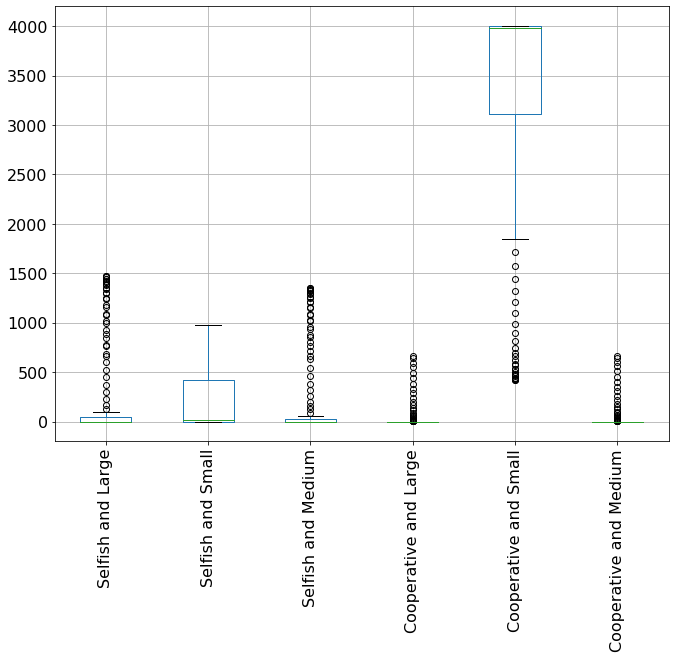

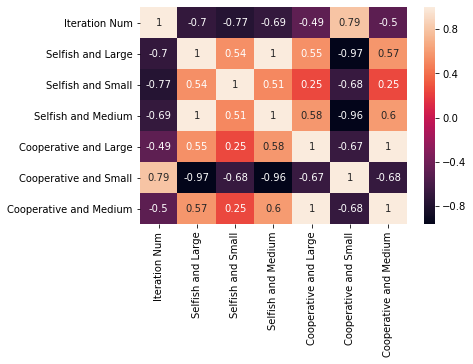

In [4]:
stats(df)

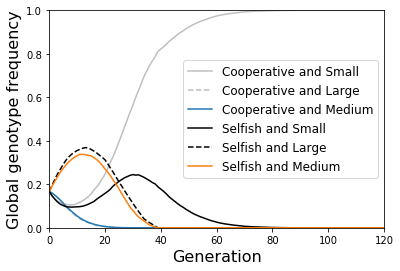

In [5]:
tot = (df['Selfish and Small'] + df['Selfish and Large']+ df['Selfish and Medium']+
       df['Cooperative and Large'] + df['Cooperative and Small'] + df['Cooperative and Medium'])

plt.plot(df['Iteration Num'], df['Cooperative and Small']/tot, '0.75', label = 'Cooperative and Small')
plt.plot(df['Iteration Num'], df['Cooperative and Large']/tot, '--', color= '0.75', label = 'Cooperative and Large')
plt.plot(df['Iteration Num'], df['Cooperative and Medium']/tot, label = 'Cooperative and Medium')
plt.plot(df['Iteration Num'], df['Selfish and Small']/tot, 'k', label = 'Selfish and Small')
plt.plot(df['Iteration Num'], df['Selfish and Large']/tot, 'k--', label = 'Selfish and Large')
plt.plot(df['Iteration Num'], df['Selfish and Medium']/tot, label = 'Selfish and Medium')
plt.xlim(0, 120)
plt.ylim(0, 1)
plt.xlabel("Generation", fontsize=16)
plt.ylabel("Global genotype frequency", fontsize=16)
plt.legend(fontsize=12)

## Disposal Time = 2

In [6]:
pop = 4000
iter_num = 150
d = {'Iteration Num': [0], 'Selfish and Large': [666], 'Selfish and Small': [666], 'Selfish and Medium': [666],
     'Cooperative and Large': [666], 'Cooperative and Small': [666], 'Cooperative and Medium': [666]}
df = pd.DataFrame(data=d)
migrant_pool = create_pool(pop)
for i in range(1, iter_num + 1):
    large_group, small_group, medium_group = divide_in_groups(migrant_pool)
    large_group, small_group, medium_group = reproduction(large_group, small_group, medium_group, disposal_limit= 2)
    migrant_pool = update_pool(large_group, small_group, medium_group)
    unique, counts = np.unique(migrant_pool, return_counts=True)
    res_counts = dict(zip(unique, counts))
    df = df.append({"Iteration Num": i,
                    "Selfish and Large": res_counts.get('SL', 0),
                    "Selfish and Small": res_counts.get('SS', 0),
                    "Selfish and Medium": res_counts.get('SM', 0),
                    "Cooperative and Large": res_counts.get('CL', 0),
                    "Cooperative and Small": res_counts.get('CS', 0),
                    "Cooperative and Medium": res_counts.get('CM', 0)
                    }, ignore_index=True)
    if i % 50 == 0:
        print('Iteration Number:', i)

Iteration Number: 50
Iteration Number: 100
Iteration Number: 150


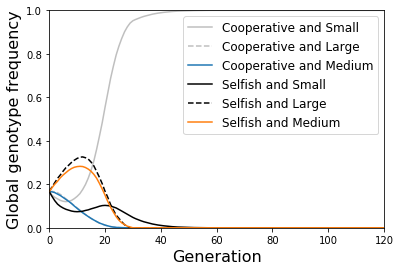

In [7]:
tot = (df['Selfish and Small'] + df['Selfish and Large']+ df['Selfish and Medium']+
       df['Cooperative and Large'] + df['Cooperative and Small'] + df['Cooperative and Medium'])

plt.plot(df['Iteration Num'], df['Cooperative and Small']/tot, '0.75', label = 'Cooperative and Small')
plt.plot(df['Iteration Num'], df['Cooperative and Large']/tot, '--', color= '0.75', label = 'Cooperative and Large')
plt.plot(df['Iteration Num'], df['Cooperative and Medium']/tot, label = 'Cooperative and Medium')
plt.plot(df['Iteration Num'], df['Selfish and Small']/tot, 'k', label = 'Selfish and Small')
plt.plot(df['Iteration Num'], df['Selfish and Large']/tot, 'k--', label = 'Selfish and Large')
plt.plot(df['Iteration Num'], df['Selfish and Medium']/tot, label = 'Selfish and Medium')
plt.xlim(0, 120)
plt.ylim(0, 1)
plt.xlabel("Generation", fontsize=16)
plt.ylabel("Global genotype frequency", fontsize=16)
plt.legend(fontsize=12)

## Disposal Time = 6

In [8]:
pop = 4000
iter_num = 150
d = {'Iteration Num': [0], 'Selfish and Large': [666], 'Selfish and Small': [666], 'Selfish and Medium': [666],
     'Cooperative and Large': [666], 'Cooperative and Small': [666], 'Cooperative and Medium': [666]}
df = pd.DataFrame(data=d)
migrant_pool = create_pool(pop)
for i in range(1, iter_num + 1):
    large_group, small_group, medium_group = divide_in_groups(migrant_pool)
    large_group, small_group, medium_group = reproduction(large_group, small_group, medium_group, disposal_limit= 6)
    migrant_pool = update_pool(large_group, small_group, medium_group)
    unique, counts = np.unique(migrant_pool, return_counts=True)
    res_counts = dict(zip(unique, counts))
    df = df.append({"Iteration Num": i,
                    "Selfish and Large": res_counts.get('SL', 0),
                    "Selfish and Small": res_counts.get('SS', 0),
                    "Selfish and Medium": res_counts.get('SM', 0),
                    "Cooperative and Large": res_counts.get('CL', 0),
                    "Cooperative and Small": res_counts.get('CS', 0),
                    "Cooperative and Medium": res_counts.get('CM', 0)
                    }, ignore_index=True)
    if i % 50 == 0:
        print('Iteration Number:', i)

Iteration Number: 50
Iteration Number: 100
Iteration Number: 150


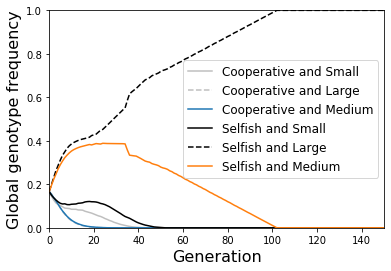

In [9]:
tot = (df['Selfish and Small'] + df['Selfish and Large']+ df['Selfish and Medium']+
       df['Cooperative and Large'] + df['Cooperative and Small'] + df['Cooperative and Medium'])

plt.plot(df['Iteration Num'], df['Cooperative and Small']/tot, '0.75', label = 'Cooperative and Small')
plt.plot(df['Iteration Num'], df['Cooperative and Large']/tot, '--', color= '0.75', label = 'Cooperative and Large')
plt.plot(df['Iteration Num'], df['Cooperative and Medium']/tot, label = 'Cooperative and Medium')
plt.plot(df['Iteration Num'], df['Selfish and Small']/tot, 'k', label = 'Selfish and Small')
plt.plot(df['Iteration Num'], df['Selfish and Large']/tot, 'k--', label = 'Selfish and Large')
plt.plot(df['Iteration Num'], df['Selfish and Medium']/tot, label = 'Selfish and Medium')
plt.xlim(0, 150)
plt.ylim(0, 1)
plt.xlabel("Generation", fontsize=16)
plt.ylabel("Global genotype frequency", fontsize=16)
plt.legend(fontsize=12)

## Adding Mutation (Disposal Time =4)

In [10]:
pop = 4000
iter_num = 1000
d = {'Iteration Num': [0], 'Selfish and Large': [666], 'Selfish and Small': [666], 'Selfish and Medium': [666],
     'Cooperative and Large': [666], 'Cooperative and Small': [666], 'Cooperative and Medium': [666]}
df = pd.DataFrame(data=d)
migrant_pool = create_pool(pop)
for i in range(1, iter_num + 1):
    large_group, small_group, medium_group = divide_in_groups(migrant_pool)
    large_group, small_group, medium_group = reproduction(large_group, small_group, medium_group)
    migrant_pool = update_pool(large_group, small_group, medium_group, mutation=True)
    unique, counts = np.unique(migrant_pool, return_counts=True)
    res_counts = dict(zip(unique, counts))
    df = df.append({"Iteration Num": i,
                    "Selfish and Large": res_counts.get('SL', 0),
                    "Selfish and Small": res_counts.get('SS', 0),
                    "Selfish and Medium": res_counts.get('SM', 0),
                    "Cooperative and Large": res_counts.get('CL', 0),
                    "Cooperative and Small": res_counts.get('CS', 0),
                    "Cooperative and Medium": res_counts.get('CM', 0)
                    }, ignore_index=True)
    if i % 50 == 0:
        print('Iteration Number:', i)

Iteration Number: 50
Iteration Number: 100
Iteration Number: 150
Iteration Number: 200
Iteration Number: 250
Iteration Number: 300
Iteration Number: 350
Iteration Number: 400
Iteration Number: 450
Iteration Number: 500
Iteration Number: 550
Iteration Number: 600
Iteration Number: 650
Iteration Number: 700
Iteration Number: 750
Iteration Number: 800
Iteration Number: 850
Iteration Number: 900
Iteration Number: 950
Iteration Number: 1000


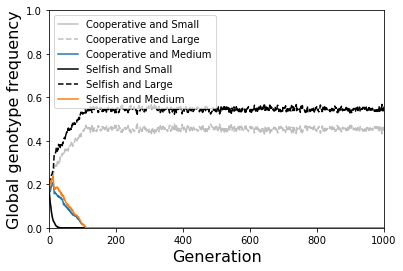

In [11]:
tot = (df['Selfish and Small'] + df['Selfish and Large']+ df['Selfish and Medium']+
       df['Cooperative and Large'] + df['Cooperative and Small'] + df['Cooperative and Medium'])

plt.plot(df['Iteration Num'], df['Cooperative and Small']/tot, '0.75', label = 'Cooperative and Small')
plt.plot(df['Iteration Num'], df['Cooperative and Large']/tot, '--', color= '0.75', label = 'Cooperative and Large')
plt.plot(df['Iteration Num'], df['Cooperative and Medium']/tot, label = 'Cooperative and Medium')
plt.plot(df['Iteration Num'], df['Selfish and Small']/tot, 'k', label = 'Selfish and Small')
plt.plot(df['Iteration Num'], df['Selfish and Large']/tot, 'k--', label = 'Selfish and Large')
plt.plot(df['Iteration Num'], df['Selfish and Medium']/tot, label = 'Selfish and Medium')
plt.xlim(0, 1000)
plt.ylim(0, 1)
plt.xlabel("Generation", fontsize=16)
plt.ylabel("Global genotype frequency", fontsize=16)
plt.legend()

## Adding Mutation (Disposal Time =2)

In [16]:
pop = 4000
iter_num = 1000
d = {'Iteration Num': [0], 'Selfish and Large': [666], 'Selfish and Small': [666], 'Selfish and Medium': [666],
     'Cooperative and Large': [666], 'Cooperative and Small': [666], 'Cooperative and Medium': [666]}
df = pd.DataFrame(data=d)
migrant_pool = create_pool(pop)
for i in range(1, iter_num + 1):
    large_group, small_group, medium_group = divide_in_groups(migrant_pool)
    large_group, small_group, medium_group = reproduction(large_group, small_group, medium_group, disposal_limit= 2)
    migrant_pool = update_pool(large_group, small_group, medium_group, mutation=True)
    unique, counts = np.unique(migrant_pool, return_counts=True)
    res_counts = dict(zip(unique, counts))
    df = df.append({"Iteration Num": i,
                    "Selfish and Large": res_counts.get('SL', 0),
                    "Selfish and Small": res_counts.get('SS', 0),
                    "Selfish and Medium": res_counts.get('SM', 0),
                    "Cooperative and Large": res_counts.get('CL', 0),
                    "Cooperative and Small": res_counts.get('CS', 0),
                    "Cooperative and Medium": res_counts.get('CM', 0)
                    }, ignore_index=True)
    if i % 50 == 0:
        print('Iteration Number:', i)

Iteration Number: 50
Iteration Number: 100
Iteration Number: 150
Iteration Number: 200
Iteration Number: 250
Iteration Number: 300
Iteration Number: 350
Iteration Number: 400
Iteration Number: 450
Iteration Number: 500
Iteration Number: 550
Iteration Number: 600
Iteration Number: 650
Iteration Number: 700
Iteration Number: 750
Iteration Number: 800
Iteration Number: 850
Iteration Number: 900
Iteration Number: 950
Iteration Number: 1000


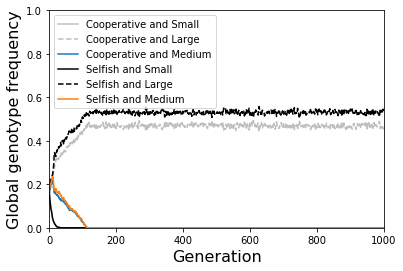

In [18]:
tot = (df['Selfish and Small'] + df['Selfish and Large']+ df['Selfish and Medium']+
       df['Cooperative and Large'] + df['Cooperative and Small'] + df['Cooperative and Medium'])

plt.plot(df['Iteration Num'], df['Cooperative and Small']/tot, '0.75', label = 'Cooperative and Small')
plt.plot(df['Iteration Num'], df['Cooperative and Large']/tot, '--', color= '0.75', label = 'Cooperative and Large')
plt.plot(df['Iteration Num'], df['Cooperative and Medium']/tot, label = 'Cooperative and Medium')
plt.plot(df['Iteration Num'], df['Selfish and Small']/tot, 'k', label = 'Selfish and Small')
plt.plot(df['Iteration Num'], df['Selfish and Large']/tot, 'k--', label = 'Selfish and Large')
plt.plot(df['Iteration Num'], df['Selfish and Medium']/tot, label = 'Selfish and Medium')
plt.xlim(0, 1000)
plt.ylim(0, 1)
plt.xlabel("Generation", fontsize=16)
plt.ylabel("Global genotype frequency", fontsize=16)
plt.legend(loc = 'upper left')

## Adding Mutation (Disposal Time =6)

In [14]:
pop = 4000
iter_num = 1000
d = {'Iteration Num': [0], 'Selfish and Large': [666], 'Selfish and Small': [666], 'Selfish and Medium': [666],
     'Cooperative and Large': [666], 'Cooperative and Small': [666], 'Cooperative and Medium': [666]}
df = pd.DataFrame(data=d)
migrant_pool = create_pool(pop)
for i in range(1, iter_num + 1):
    large_group, small_group, medium_group = divide_in_groups(migrant_pool)
    large_group, small_group, medium_group = reproduction(large_group, small_group, medium_group, disposal_limit= 6)
    migrant_pool = update_pool(large_group, small_group, medium_group, mutation=True)
    unique, counts = np.unique(migrant_pool, return_counts=True)
    res_counts = dict(zip(unique, counts))
    df = df.append({"Iteration Num": i,
                    "Selfish and Large": res_counts.get('SL', 0),
                    "Selfish and Small": res_counts.get('SS', 0),
                    "Selfish and Medium": res_counts.get('SM', 0),
                    "Cooperative and Large": res_counts.get('CL', 0),
                    "Cooperative and Small": res_counts.get('CS', 0),
                    "Cooperative and Medium": res_counts.get('CM', 0)
                    }, ignore_index=True)
    if i % 50 == 0:
        print('Iteration Number:', i)

Iteration Number: 50
Iteration Number: 100
Iteration Number: 150
Iteration Number: 200
Iteration Number: 250
Iteration Number: 300
Iteration Number: 350
Iteration Number: 400
Iteration Number: 450
Iteration Number: 500
Iteration Number: 550
Iteration Number: 600
Iteration Number: 650
Iteration Number: 700
Iteration Number: 750
Iteration Number: 800
Iteration Number: 850
Iteration Number: 900
Iteration Number: 950
Iteration Number: 1000


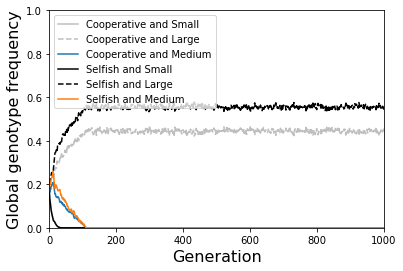

In [15]:
tot = (df['Selfish and Small'] + df['Selfish and Large']+ df['Selfish and Medium']+
       df['Cooperative and Large'] + df['Cooperative and Small'] + df['Cooperative and Medium'])

plt.plot(df['Iteration Num'], df['Cooperative and Small']/tot, '0.75', label = 'Cooperative and Small')
plt.plot(df['Iteration Num'], df['Cooperative and Large']/tot, '--', color= '0.75', label = 'Cooperative and Large')
plt.plot(df['Iteration Num'], df['Cooperative and Medium']/tot, label = 'Cooperative and Medium')
plt.plot(df['Iteration Num'], df['Selfish and Small']/tot, 'k', label = 'Selfish and Small')
plt.plot(df['Iteration Num'], df['Selfish and Large']/tot, 'k--', label = 'Selfish and Large')
plt.plot(df['Iteration Num'], df['Selfish and Medium']/tot, label = 'Selfish and Medium')
plt.xlim(0, 1000)
plt.ylim(0, 1)
plt.xlabel("Generation", fontsize=16)
plt.ylabel("Global genotype frequency", fontsize=16)
plt.legend()